## Part A. Document Clustering
In this part, you solve a document clustering problem using unsupervised learning algorithms (i.e., soft and hard Expectation Maximization) for document clustering.

In [ ]:
#libraries to be imported
library(tm)
library(dplyr)
library(SnowballC)

### Question 1: EM for Document Clustering

>##### 1.Derive Expectation and Maximization steps of the hard-EM algorithm for Document Clustering

The derivation of EM for hard-EM for document clustering is reported in PDF attached in the submission.

> ##### 2. Implementation of the Hard-EM and Soft-EM.\

In [39]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 

# defining eps to handle NaN values
eps=1e-10
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1] # number of clusters
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

In [40]:
#Input: logA1, logA2 ... logAn
#Output:log(A1+A2+...+An)
#This function is needed to prevent numerical overflow/underflow when working with small numbers, 
#because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   

logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [41]:
##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

In [42]:
##--- Cluster Visualization -------------------------------------------------
# Function to visualize estimated clusters
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

In [43]:
##--- E Step for Document Clustering  --------------------------------------------
#calculate expectation for soft clustering
E_soft <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1] # number of clusters
  # E step:    
  for (n in 1:N){
     for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
      }
      # normalisation to sum to 1 in the log space
      logZ = logSum(gamma[n,])
      gamma[n,] = gamma[n,] - logZ
      }
      #converting back 
      gamma <- exp(gamma)
       return (gamma)
     }

In [44]:
# Calculate expectation for hard clustering
E_hard <- function(gamma, model, counts){
          # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1] # number of clusters
  #Expectation step:
        for (n in 1:N){
            for (k in 1:K){
              ## calculate the posterior based on the estimated mu and rho in the "log space"
              gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
            }
            # normalising the sum to 1 in the log space
            logZ = logSum(gamma[n,])
            gamma[n,] = gamma[n,] - logZ
          }
  # Now hard assignment to the clusters
      # calculating the cluster with max post probability from gamma
        max.prob <- gamma==apply(gamma, 1, max) 
        gamma[!max.prob] <- 0 # Hard assign each point  with its respective probabilities
        gamma[max.prob] <- 1 # Else 1
     return (gamma)
}

In [45]:
#calculating the maximization 
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
  eps=1e-10 # a small number to prevent NA values
  Nk.hat <- model$rho   # cluster sizes
  mu <- model$mu  # clusters  

 for (k in 1:K){
       # the effective number of point in cluster k    
       Nk.hat[k]<-sum(gamma[,k])/N
      }
    # assign that probability of each cluster
    model$rho<-Nk.hat
 for (k in 1:K){
      for (w in 1:W)
        {     
           # step to calculate probability that the word belongs to all the clusters and adding eps to prevent values becoming Nan
            prob<-(counts[w,] * gamma[,k]) + eps
           # Calculating the class probabilities for each word
            mu[k,w]<-sum(prob* gamma[,k])/(sum(counts * gamma[,k])+K*eps)
        }
    }
    # normalizing
    model$mu<-prop.table(mu, margin = 1)
  # Return the result
  return (model)
}

In [46]:
#Soft maximization
soft_EM<- function(counts, K=4, max.epoch=10, seed=123456){
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

     # Build the model
              for(epoch in 1:max.epoch){

                    # E Step
                    gamma <- E_soft(gamma, model, counts)


                    # M Step
                    model <- M.step(gamma, model, counts)

              }
              # Return Model
              return(list("model"=model,"gamma"=gamma))}

In [47]:
#Hard maximization
hard_EM<- function(counts, K=4, max.epoch=10, seed=123456){ 
     # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)
  # Build the model
  for(epoch in 1:max.epoch){
  # Expectation Step
      gamma <- E_hard(gamma, model, counts)
  # Maximizing Step
      model <- M.step(gamma, model, counts)
   }
   return(list("model"=model,"gamma"=gamma)) #return the model
}

>##### 3. Loading the dataset and preprocessing it for the use.

In [48]:
# reading
  read.data <- function(file.name='Task2A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(doc_id=1:length(docs),text=unlist(lapply(docs, function(x) x[2])))
   # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}


>##### 4. Performing PCA on the clusters that we get based on the hard-EM and soft-EM 
Implementing Soft EM

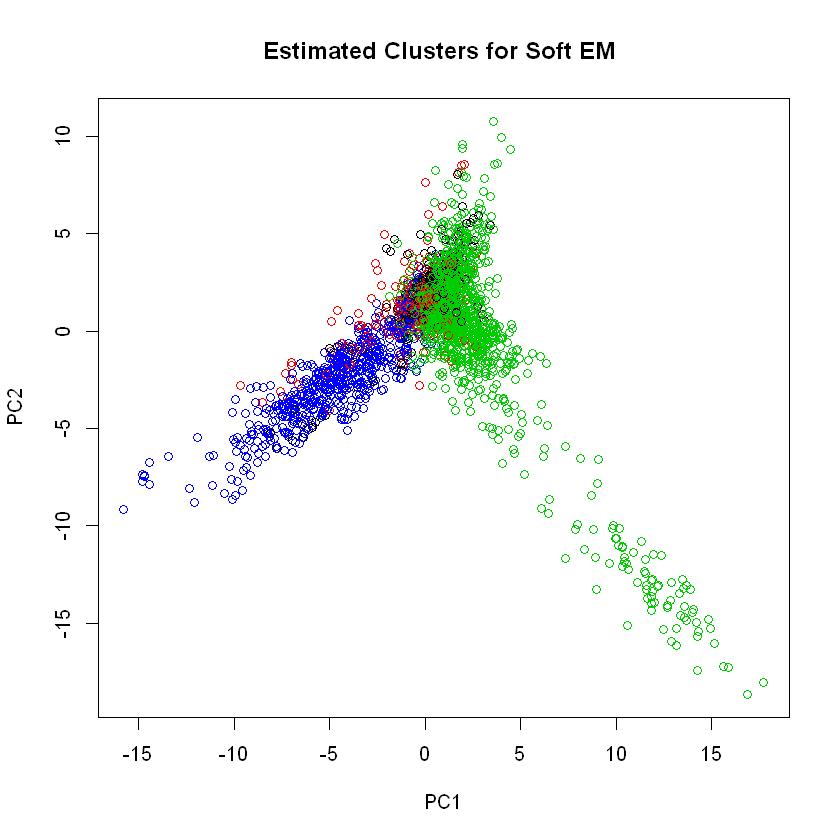

In [49]:
# Reading
dataset <- read.data('Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)
# frequency matrix 
freq <- dataset$word.doc.mat        
soft <- soft_EM(freq, K=4, max.epoch=5)   
# visualization
#finding clusters with maximum probabililty
label.hat <- apply(soft$gamma, 1, which.max) 
freq<-scale(freq) # normalizing for better visualization
#visualizing
cluster.viz(t(freq), label.hat, 'Estimated Clusters for Soft EM ')

 > Implementing Hard EM

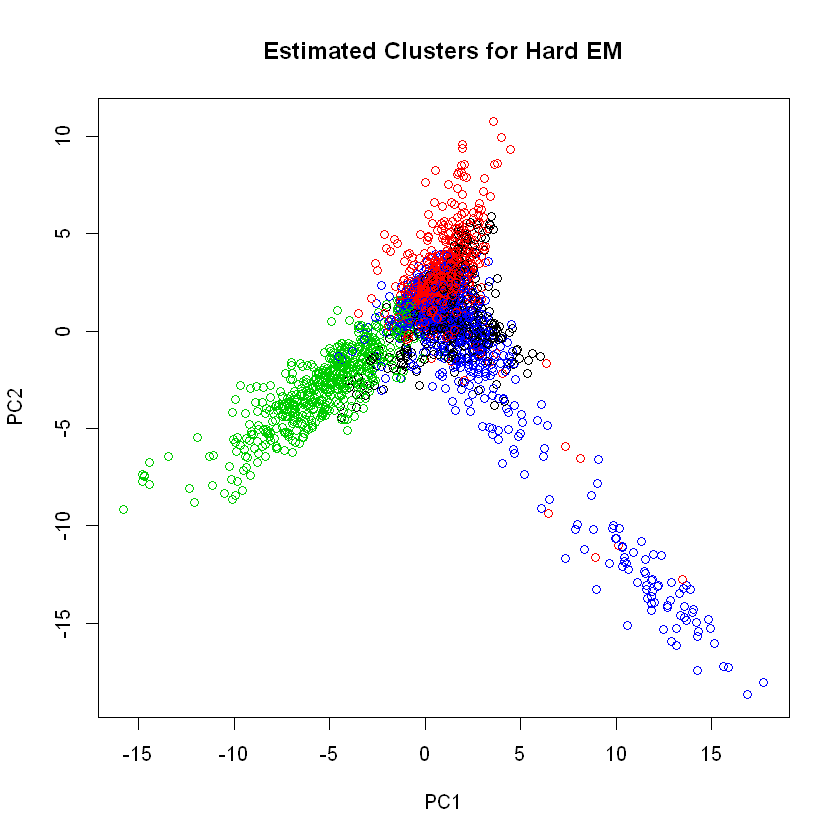

In [50]:
# Reading
dataset <- read.data('Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)
# frequency matrix 
freq <- dataset$word.doc.mat        
# calling the EM algorithm on the data
hard <- hard_EM(freq, K=4, max.epoch=5)   
# visualization
#finding clusters with maximum probabililty
label.hat <- apply(hard$gamma, 1, which.max) 
freq<-scale(freq)  # normalizing for better visualization
#visualizing
cluster.viz(t(freq), label.hat, 'Estimated Clusters for Hard EM')

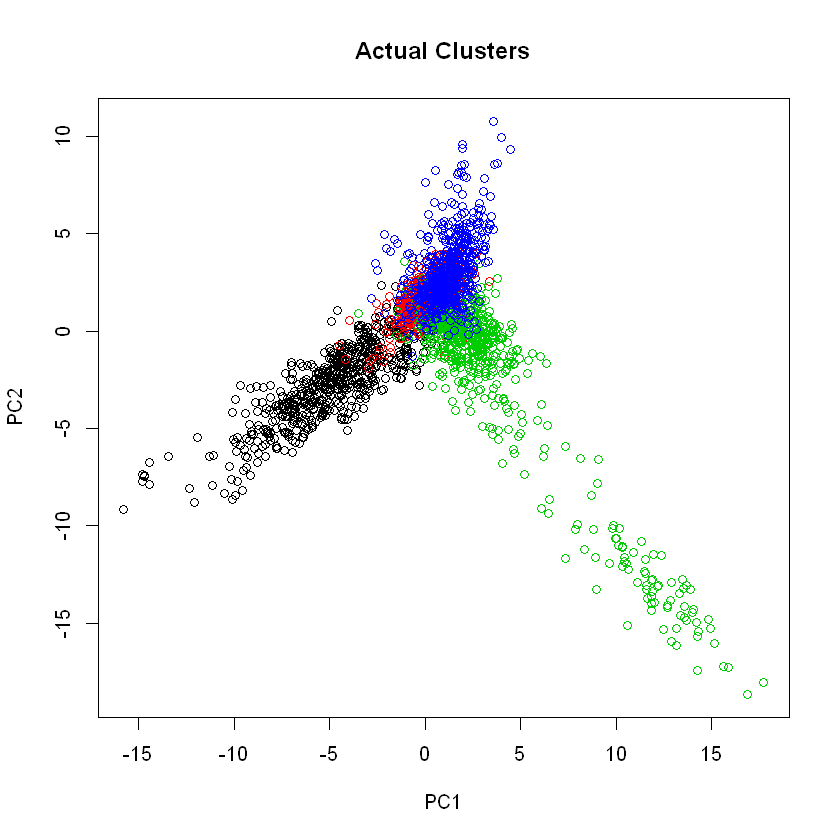

In [51]:
## visualize actual clusters
cluster.viz(t(freq), factor(dataset$label), 'Actual Clusters')